In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import models
import utils
from vision_transformer import DINOHead
import vision_transformer as vits
import math
from tqdm import tqdm

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

import matplotlib
matplotlib.rc('font', **font)

/home/grantsrb/anaconda3/envs/dino/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

def unnormalize(X):
    """
    X: torch tensor or ndarray (..., 3, H, W)
    """
    if isinstance(X, type(np.ones((1,)))):
        means = np.asarray([0.485, 0.456, 0.406])
        stds =  np.asarray([0.229, 0.224, 0.225])
    else:
        means = torch.FloatTensor([0.485, 0.456, 0.406])
        stds = torch.FloatTensor([0.229, 0.224, 0.225])
    return X*stds[:,None,None] + means[:,None,None]

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
X_train = torch.FloatTensor(trainset.data).permute(0,3,1,2)
y_train = torch.LongTensor(trainset.targets)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
X_test = torch.FloatTensor(testset.data).permute(0,3,1,2)
y_test = torch.LongTensor( testset.targets)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Parameter Count

In [51]:
#checkpt_path = "/data2/pdp/grantsrb/dinoclr_saves/chans8-16-32-48AvgOverDim/checkpoint.pth"
#checkpt_path = "/data2/pdp/grantsrb/dinoclr_saves/chans8-16-32-48RecurrentAttention/checkpoint.pth"
#checkpt_path = "/mnt/fs1/grantsrb/dinoclr_saves/chans8-16-32-48AttentionalJoin/checkpoint.pth"
#checkpt_path = "/mnt/fs1/grantsrb/dinoclr_saves/chans8-16-32-48DenseJoin/checkpoint.pth"

checkpt_path = "/data2/pdp/grantsrb/dinoclr_saves/resnet50AvgDim/checkpoint.pth"

#checkpt_path = "/data2/pdp/grantsrb/dinoclr_saves/chans8-16-32-48AvgOverDim16000/checkpoint.pth"

# Model1
#checkpt_path = "/mnt/fs1/grantsrb/dinoclr_saves/chans12-16-24-36-48ksizes2ncnns6aggdim128share/checkpoint.pth"
#checkpt_path = "/mnt/fs1/grantsrb/dinoclr_saves/chans8-16-24-48ksizes2ncnns8attnjoin/checkpoint.pth"
#checkpt_path = "/mnt/fs1/grantsrb/dinoclr_saves/chans8-16-24-48ksizes2ncnns104/checkpoint.pth"
# ViT Baseline
#checkpt_path = "/mnt/fs1/grantsrb/dinoclr_saves/vit_tiny_baseline/checkpoint.pth"
# OG Model
#checkpt_path = "/mnt/fs1/grantsrb/dinoclr_saves/avgpoolchans8-16-24-48-128ksizes2/checkpoint.pth"
checkpt = torch.load(checkpt_path, map_location='cpu')
args = checkpt["args"]
if args.arch in vits.__dict__.keys():                                  
    hyps = {                                                           
        "patch_size": args.patch_size,                                 
        "img_size": [32]
    }                                                                  
    teacher = vits.__dict__[args.arch]( **hyps )                       
    embed_dim = teacher.embed_dim
elif args.arch in models.__dict__.keys():                              
    try:
        hyps = checkpt["hyps"]
    except:
        hyps = {
            "n_cnns": 8, "inpt_shape": (3,32,32), "chans": [8,16,24,48,96],
            "ksizes": 2, "strides": 1, "paddings": 0, "lnorm": True, "out_dim": 65536,
        }                                                                  
    teacher = models.__dict__[args.arch](**hyps)                       
    embed_dim = hyps["agg_dim"] if "out_dim" not in hyps else hyps["out_dim"] 
model = utils.MultiCropWrapper(                                      
    teacher,                                                           
    DINOHead(embed_dim, args.out_dim, False),            
)
model.load_state_dict(checkpt["teacher"])
count = 0
for p in teacher.parameters():
    count += math.prod(p.shape)
print("Param Count (No Multicrop Wrapper):", count)
count = 0
for p in model.parameters():
    count += math.prod(p.shape)
print("Param Count (total):", count)
model = model.backbone

/home/grantsrb/anaconda3/envs/dino/lib/python3.9/site-packages/torchvision/models/_utils.py:207: UserWarning: The parameter 'pretrained' is deprecated, please use 'weights' instead.
  warnings.warn(
/home/grantsrb/anaconda3/envs/dino/lib/python3.9/site-packages/torchvision/models/_utils.py:220: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


temp agg torch.Size([1, 128])


RuntimeError: Error(s) in loading state_dict for MultiCropWrapper:
	Missing key(s) in state_dict: "backbone.features.0.weight", "backbone.features.1.weight", "backbone.features.1.bias", "backbone.features.1.running_mean", "backbone.features.1.running_var", "backbone.features.4.0.conv1.weight", "backbone.features.4.0.bn1.weight", "backbone.features.4.0.bn1.bias", "backbone.features.4.0.bn1.running_mean", "backbone.features.4.0.bn1.running_var", "backbone.features.4.0.conv2.weight", "backbone.features.4.0.bn2.weight", "backbone.features.4.0.bn2.bias", "backbone.features.4.0.bn2.running_mean", "backbone.features.4.0.bn2.running_var", "backbone.features.4.0.conv3.weight", "backbone.features.4.0.bn3.weight", "backbone.features.4.0.bn3.bias", "backbone.features.4.0.bn3.running_mean", "backbone.features.4.0.bn3.running_var", "backbone.features.4.0.downsample.0.weight", "backbone.features.4.0.downsample.1.weight", "backbone.features.4.0.downsample.1.bias", "backbone.features.4.0.downsample.1.running_mean", "backbone.features.4.0.downsample.1.running_var", "backbone.features.4.1.conv1.weight", "backbone.features.4.1.bn1.weight", "backbone.features.4.1.bn1.bias", "backbone.features.4.1.bn1.running_mean", "backbone.features.4.1.bn1.running_var", "backbone.features.4.1.conv2.weight", "backbone.features.4.1.bn2.weight", "backbone.features.4.1.bn2.bias", "backbone.features.4.1.bn2.running_mean", "backbone.features.4.1.bn2.running_var", "backbone.features.4.1.conv3.weight", "backbone.features.4.1.bn3.weight", "backbone.features.4.1.bn3.bias", "backbone.features.4.1.bn3.running_mean", "backbone.features.4.1.bn3.running_var", "backbone.features.4.2.conv1.weight", "backbone.features.4.2.bn1.weight", "backbone.features.4.2.bn1.bias", "backbone.features.4.2.bn1.running_mean", "backbone.features.4.2.bn1.running_var", "backbone.features.4.2.conv2.weight", "backbone.features.4.2.bn2.weight", "backbone.features.4.2.bn2.bias", "backbone.features.4.2.bn2.running_mean", "backbone.features.4.2.bn2.running_var", "backbone.features.4.2.conv3.weight", "backbone.features.4.2.bn3.weight", "backbone.features.4.2.bn3.bias", "backbone.features.4.2.bn3.running_mean", "backbone.features.4.2.bn3.running_var", "backbone.features.5.0.conv1.weight", "backbone.features.5.0.bn1.weight", "backbone.features.5.0.bn1.bias", "backbone.features.5.0.bn1.running_mean", "backbone.features.5.0.bn1.running_var", "backbone.features.5.0.conv2.weight", "backbone.features.5.0.bn2.weight", "backbone.features.5.0.bn2.bias", "backbone.features.5.0.bn2.running_mean", "backbone.features.5.0.bn2.running_var", "backbone.features.5.0.conv3.weight", "backbone.features.5.0.bn3.weight", "backbone.features.5.0.bn3.bias", "backbone.features.5.0.bn3.running_mean", "backbone.features.5.0.bn3.running_var", "backbone.features.5.0.downsample.0.weight", "backbone.features.5.0.downsample.1.weight", "backbone.features.5.0.downsample.1.bias", "backbone.features.5.0.downsample.1.running_mean", "backbone.features.5.0.downsample.1.running_var", "backbone.features.5.1.conv1.weight", "backbone.features.5.1.bn1.weight", "backbone.features.5.1.bn1.bias", "backbone.features.5.1.bn1.running_mean", "backbone.features.5.1.bn1.running_var", "backbone.features.5.1.conv2.weight", "backbone.features.5.1.bn2.weight", "backbone.features.5.1.bn2.bias", "backbone.features.5.1.bn2.running_mean", "backbone.features.5.1.bn2.running_var", "backbone.features.5.1.conv3.weight", "backbone.features.5.1.bn3.weight", "backbone.features.5.1.bn3.bias", "backbone.features.5.1.bn3.running_mean", "backbone.features.5.1.bn3.running_var", "backbone.features.5.2.conv1.weight", "backbone.features.5.2.bn1.weight", "backbone.features.5.2.bn1.bias", "backbone.features.5.2.bn1.running_mean", "backbone.features.5.2.bn1.running_var", "backbone.features.5.2.conv2.weight", "backbone.features.5.2.bn2.weight", "backbone.features.5.2.bn2.bias", "backbone.features.5.2.bn2.running_mean", "backbone.features.5.2.bn2.running_var", "backbone.features.5.2.conv3.weight", "backbone.features.5.2.bn3.weight", "backbone.features.5.2.bn3.bias", "backbone.features.5.2.bn3.running_mean", "backbone.features.5.2.bn3.running_var", "backbone.features.5.3.conv1.weight", "backbone.features.5.3.bn1.weight", "backbone.features.5.3.bn1.bias", "backbone.features.5.3.bn1.running_mean", "backbone.features.5.3.bn1.running_var", "backbone.features.5.3.conv2.weight", "backbone.features.5.3.bn2.weight", "backbone.features.5.3.bn2.bias", "backbone.features.5.3.bn2.running_mean", "backbone.features.5.3.bn2.running_var", "backbone.features.5.3.conv3.weight", "backbone.features.5.3.bn3.weight", "backbone.features.5.3.bn3.bias", "backbone.features.5.3.bn3.running_mean", "backbone.features.5.3.bn3.running_var", "backbone.dense.1.weight", "backbone.dense.1.bias", "backbone.dense.2.weight", "backbone.dense.2.bias", "backbone.dense.4.weight", "backbone.dense.4.bias", "backbone.dense.5.weight", "backbone.dense.5.bias", "backbone.net.0.0.weight", "backbone.net.0.1.weight", "backbone.net.0.1.bias", "backbone.net.0.1.running_mean", "backbone.net.0.1.running_var", "backbone.net.0.4.0.conv1.weight", "backbone.net.0.4.0.bn1.weight", "backbone.net.0.4.0.bn1.bias", "backbone.net.0.4.0.bn1.running_mean", "backbone.net.0.4.0.bn1.running_var", "backbone.net.0.4.0.conv2.weight", "backbone.net.0.4.0.bn2.weight", "backbone.net.0.4.0.bn2.bias", "backbone.net.0.4.0.bn2.running_mean", "backbone.net.0.4.0.bn2.running_var", "backbone.net.0.4.0.conv3.weight", "backbone.net.0.4.0.bn3.weight", "backbone.net.0.4.0.bn3.bias", "backbone.net.0.4.0.bn3.running_mean", "backbone.net.0.4.0.bn3.running_var", "backbone.net.0.4.0.downsample.0.weight", "backbone.net.0.4.0.downsample.1.weight", "backbone.net.0.4.0.downsample.1.bias", "backbone.net.0.4.0.downsample.1.running_mean", "backbone.net.0.4.0.downsample.1.running_var", "backbone.net.0.4.1.conv1.weight", "backbone.net.0.4.1.bn1.weight", "backbone.net.0.4.1.bn1.bias", "backbone.net.0.4.1.bn1.running_mean", "backbone.net.0.4.1.bn1.running_var", "backbone.net.0.4.1.conv2.weight", "backbone.net.0.4.1.bn2.weight", "backbone.net.0.4.1.bn2.bias", "backbone.net.0.4.1.bn2.running_mean", "backbone.net.0.4.1.bn2.running_var", "backbone.net.0.4.1.conv3.weight", "backbone.net.0.4.1.bn3.weight", "backbone.net.0.4.1.bn3.bias", "backbone.net.0.4.1.bn3.running_mean", "backbone.net.0.4.1.bn3.running_var", "backbone.net.0.4.2.conv1.weight", "backbone.net.0.4.2.bn1.weight", "backbone.net.0.4.2.bn1.bias", "backbone.net.0.4.2.bn1.running_mean", "backbone.net.0.4.2.bn1.running_var", "backbone.net.0.4.2.conv2.weight", "backbone.net.0.4.2.bn2.weight", "backbone.net.0.4.2.bn2.bias", "backbone.net.0.4.2.bn2.running_mean", "backbone.net.0.4.2.bn2.running_var", "backbone.net.0.4.2.conv3.weight", "backbone.net.0.4.2.bn3.weight", "backbone.net.0.4.2.bn3.bias", "backbone.net.0.4.2.bn3.running_mean", "backbone.net.0.4.2.bn3.running_var", "backbone.net.0.5.0.conv1.weight", "backbone.net.0.5.0.bn1.weight", "backbone.net.0.5.0.bn1.bias", "backbone.net.0.5.0.bn1.running_mean", "backbone.net.0.5.0.bn1.running_var", "backbone.net.0.5.0.conv2.weight", "backbone.net.0.5.0.bn2.weight", "backbone.net.0.5.0.bn2.bias", "backbone.net.0.5.0.bn2.running_mean", "backbone.net.0.5.0.bn2.running_var", "backbone.net.0.5.0.conv3.weight", "backbone.net.0.5.0.bn3.weight", "backbone.net.0.5.0.bn3.bias", "backbone.net.0.5.0.bn3.running_mean", "backbone.net.0.5.0.bn3.running_var", "backbone.net.0.5.0.downsample.0.weight", "backbone.net.0.5.0.downsample.1.weight", "backbone.net.0.5.0.downsample.1.bias", "backbone.net.0.5.0.downsample.1.running_mean", "backbone.net.0.5.0.downsample.1.running_var", "backbone.net.0.5.1.conv1.weight", "backbone.net.0.5.1.bn1.weight", "backbone.net.0.5.1.bn1.bias", "backbone.net.0.5.1.bn1.running_mean", "backbone.net.0.5.1.bn1.running_var", "backbone.net.0.5.1.conv2.weight", "backbone.net.0.5.1.bn2.weight", "backbone.net.0.5.1.bn2.bias", "backbone.net.0.5.1.bn2.running_mean", "backbone.net.0.5.1.bn2.running_var", "backbone.net.0.5.1.conv3.weight", "backbone.net.0.5.1.bn3.weight", "backbone.net.0.5.1.bn3.bias", "backbone.net.0.5.1.bn3.running_mean", "backbone.net.0.5.1.bn3.running_var", "backbone.net.0.5.2.conv1.weight", "backbone.net.0.5.2.bn1.weight", "backbone.net.0.5.2.bn1.bias", "backbone.net.0.5.2.bn1.running_mean", "backbone.net.0.5.2.bn1.running_var", "backbone.net.0.5.2.conv2.weight", "backbone.net.0.5.2.bn2.weight", "backbone.net.0.5.2.bn2.bias", "backbone.net.0.5.2.bn2.running_mean", "backbone.net.0.5.2.bn2.running_var", "backbone.net.0.5.2.conv3.weight", "backbone.net.0.5.2.bn3.weight", "backbone.net.0.5.2.bn3.bias", "backbone.net.0.5.2.bn3.running_mean", "backbone.net.0.5.2.bn3.running_var", "backbone.net.0.5.3.conv1.weight", "backbone.net.0.5.3.bn1.weight", "backbone.net.0.5.3.bn1.bias", "backbone.net.0.5.3.bn1.running_mean", "backbone.net.0.5.3.bn1.running_var", "backbone.net.0.5.3.conv2.weight", "backbone.net.0.5.3.bn2.weight", "backbone.net.0.5.3.bn2.bias", "backbone.net.0.5.3.bn2.running_mean", "backbone.net.0.5.3.bn2.running_var", "backbone.net.0.5.3.conv3.weight", "backbone.net.0.5.3.bn3.weight", "backbone.net.0.5.3.bn3.bias", "backbone.net.0.5.3.bn3.running_mean", "backbone.net.0.5.3.bn3.running_var", "backbone.net.5.1.weight", "backbone.net.5.1.bias", "backbone.net.5.2.weight", "backbone.net.5.2.bias", "backbone.net.5.4.weight", "backbone.net.5.4.bias", "backbone.net.5.5.weight", "backbone.net.5.5.bias", "head.mlp.0.weight", "head.mlp.0.bias", "head.mlp.2.weight", "head.mlp.2.bias", "head.mlp.4.weight", "head.mlp.4.bias", "head.last_layer.weight_g", "head.last_layer.weight_v". 
	Unexpected key(s) in state_dict: "module.backbone.features.0.weight", "module.backbone.features.1.weight", "module.backbone.features.1.bias", "module.backbone.features.1.running_mean", "module.backbone.features.1.running_var", "module.backbone.features.1.num_batches_tracked", "module.backbone.features.4.0.conv1.weight", "module.backbone.features.4.0.bn1.weight", "module.backbone.features.4.0.bn1.bias", "module.backbone.features.4.0.bn1.running_mean", "module.backbone.features.4.0.bn1.running_var", "module.backbone.features.4.0.bn1.num_batches_tracked", "module.backbone.features.4.0.conv2.weight", "module.backbone.features.4.0.bn2.weight", "module.backbone.features.4.0.bn2.bias", "module.backbone.features.4.0.bn2.running_mean", "module.backbone.features.4.0.bn2.running_var", "module.backbone.features.4.0.bn2.num_batches_tracked", "module.backbone.features.4.0.conv3.weight", "module.backbone.features.4.0.bn3.weight", "module.backbone.features.4.0.bn3.bias", "module.backbone.features.4.0.bn3.running_mean", "module.backbone.features.4.0.bn3.running_var", "module.backbone.features.4.0.bn3.num_batches_tracked", "module.backbone.features.4.0.downsample.0.weight", "module.backbone.features.4.0.downsample.1.weight", "module.backbone.features.4.0.downsample.1.bias", "module.backbone.features.4.0.downsample.1.running_mean", "module.backbone.features.4.0.downsample.1.running_var", "module.backbone.features.4.0.downsample.1.num_batches_tracked", "module.backbone.features.4.1.conv1.weight", "module.backbone.features.4.1.bn1.weight", "module.backbone.features.4.1.bn1.bias", "module.backbone.features.4.1.bn1.running_mean", "module.backbone.features.4.1.bn1.running_var", "module.backbone.features.4.1.bn1.num_batches_tracked", "module.backbone.features.4.1.conv2.weight", "module.backbone.features.4.1.bn2.weight", "module.backbone.features.4.1.bn2.bias", "module.backbone.features.4.1.bn2.running_mean", "module.backbone.features.4.1.bn2.running_var", "module.backbone.features.4.1.bn2.num_batches_tracked", "module.backbone.features.4.1.conv3.weight", "module.backbone.features.4.1.bn3.weight", "module.backbone.features.4.1.bn3.bias", "module.backbone.features.4.1.bn3.running_mean", "module.backbone.features.4.1.bn3.running_var", "module.backbone.features.4.1.bn3.num_batches_tracked", "module.backbone.features.4.2.conv1.weight", "module.backbone.features.4.2.bn1.weight", "module.backbone.features.4.2.bn1.bias", "module.backbone.features.4.2.bn1.running_mean", "module.backbone.features.4.2.bn1.running_var", "module.backbone.features.4.2.bn1.num_batches_tracked", "module.backbone.features.4.2.conv2.weight", "module.backbone.features.4.2.bn2.weight", "module.backbone.features.4.2.bn2.bias", "module.backbone.features.4.2.bn2.running_mean", "module.backbone.features.4.2.bn2.running_var", "module.backbone.features.4.2.bn2.num_batches_tracked", "module.backbone.features.4.2.conv3.weight", "module.backbone.features.4.2.bn3.weight", "module.backbone.features.4.2.bn3.bias", "module.backbone.features.4.2.bn3.running_mean", "module.backbone.features.4.2.bn3.running_var", "module.backbone.features.4.2.bn3.num_batches_tracked", "module.backbone.features.5.0.conv1.weight", "module.backbone.features.5.0.bn1.weight", "module.backbone.features.5.0.bn1.bias", "module.backbone.features.5.0.bn1.running_mean", "module.backbone.features.5.0.bn1.running_var", "module.backbone.features.5.0.bn1.num_batches_tracked", "module.backbone.features.5.0.conv2.weight", "module.backbone.features.5.0.bn2.weight", "module.backbone.features.5.0.bn2.bias", "module.backbone.features.5.0.bn2.running_mean", "module.backbone.features.5.0.bn2.running_var", "module.backbone.features.5.0.bn2.num_batches_tracked", "module.backbone.features.5.0.conv3.weight", "module.backbone.features.5.0.bn3.weight", "module.backbone.features.5.0.bn3.bias", "module.backbone.features.5.0.bn3.running_mean", "module.backbone.features.5.0.bn3.running_var", "module.backbone.features.5.0.bn3.num_batches_tracked", "module.backbone.features.5.0.downsample.0.weight", "module.backbone.features.5.0.downsample.1.weight", "module.backbone.features.5.0.downsample.1.bias", "module.backbone.features.5.0.downsample.1.running_mean", "module.backbone.features.5.0.downsample.1.running_var", "module.backbone.features.5.0.downsample.1.num_batches_tracked", "module.backbone.features.5.1.conv1.weight", "module.backbone.features.5.1.bn1.weight", "module.backbone.features.5.1.bn1.bias", "module.backbone.features.5.1.bn1.running_mean", "module.backbone.features.5.1.bn1.running_var", "module.backbone.features.5.1.bn1.num_batches_tracked", "module.backbone.features.5.1.conv2.weight", "module.backbone.features.5.1.bn2.weight", "module.backbone.features.5.1.bn2.bias", "module.backbone.features.5.1.bn2.running_mean", "module.backbone.features.5.1.bn2.running_var", "module.backbone.features.5.1.bn2.num_batches_tracked", "module.backbone.features.5.1.conv3.weight", "module.backbone.features.5.1.bn3.weight", "module.backbone.features.5.1.bn3.bias", "module.backbone.features.5.1.bn3.running_mean", "module.backbone.features.5.1.bn3.running_var", "module.backbone.features.5.1.bn3.num_batches_tracked", "module.backbone.features.5.2.conv1.weight", "module.backbone.features.5.2.bn1.weight", "module.backbone.features.5.2.bn1.bias", "module.backbone.features.5.2.bn1.running_mean", "module.backbone.features.5.2.bn1.running_var", "module.backbone.features.5.2.bn1.num_batches_tracked", "module.backbone.features.5.2.conv2.weight", "module.backbone.features.5.2.bn2.weight", "module.backbone.features.5.2.bn2.bias", "module.backbone.features.5.2.bn2.running_mean", "module.backbone.features.5.2.bn2.running_var", "module.backbone.features.5.2.bn2.num_batches_tracked", "module.backbone.features.5.2.conv3.weight", "module.backbone.features.5.2.bn3.weight", "module.backbone.features.5.2.bn3.bias", "module.backbone.features.5.2.bn3.running_mean", "module.backbone.features.5.2.bn3.running_var", "module.backbone.features.5.2.bn3.num_batches_tracked", "module.backbone.features.5.3.conv1.weight", "module.backbone.features.5.3.bn1.weight", "module.backbone.features.5.3.bn1.bias", "module.backbone.features.5.3.bn1.running_mean", "module.backbone.features.5.3.bn1.running_var", "module.backbone.features.5.3.bn1.num_batches_tracked", "module.backbone.features.5.3.conv2.weight", "module.backbone.features.5.3.bn2.weight", "module.backbone.features.5.3.bn2.bias", "module.backbone.features.5.3.bn2.running_mean", "module.backbone.features.5.3.bn2.running_var", "module.backbone.features.5.3.bn2.num_batches_tracked", "module.backbone.features.5.3.conv3.weight", "module.backbone.features.5.3.bn3.weight", "module.backbone.features.5.3.bn3.bias", "module.backbone.features.5.3.bn3.running_mean", "module.backbone.features.5.3.bn3.running_var", "module.backbone.features.5.3.bn3.num_batches_tracked", "module.backbone.dense.1.weight", "module.backbone.dense.1.bias", "module.backbone.dense.2.weight", "module.backbone.dense.2.bias", "module.backbone.dense.4.weight", "module.backbone.dense.4.bias", "module.backbone.dense.5.weight", "module.backbone.dense.5.bias", "module.backbone.net.0.0.weight", "module.backbone.net.0.1.weight", "module.backbone.net.0.1.bias", "module.backbone.net.0.1.running_mean", "module.backbone.net.0.1.running_var", "module.backbone.net.0.1.num_batches_tracked", "module.backbone.net.0.4.0.conv1.weight", "module.backbone.net.0.4.0.bn1.weight", "module.backbone.net.0.4.0.bn1.bias", "module.backbone.net.0.4.0.bn1.running_mean", "module.backbone.net.0.4.0.bn1.running_var", "module.backbone.net.0.4.0.bn1.num_batches_tracked", "module.backbone.net.0.4.0.conv2.weight", "module.backbone.net.0.4.0.bn2.weight", "module.backbone.net.0.4.0.bn2.bias", "module.backbone.net.0.4.0.bn2.running_mean", "module.backbone.net.0.4.0.bn2.running_var", "module.backbone.net.0.4.0.bn2.num_batches_tracked", "module.backbone.net.0.4.0.conv3.weight", "module.backbone.net.0.4.0.bn3.weight", "module.backbone.net.0.4.0.bn3.bias", "module.backbone.net.0.4.0.bn3.running_mean", "module.backbone.net.0.4.0.bn3.running_var", "module.backbone.net.0.4.0.bn3.num_batches_tracked", "module.backbone.net.0.4.0.downsample.0.weight", "module.backbone.net.0.4.0.downsample.1.weight", "module.backbone.net.0.4.0.downsample.1.bias", "module.backbone.net.0.4.0.downsample.1.running_mean", "module.backbone.net.0.4.0.downsample.1.running_var", "module.backbone.net.0.4.0.downsample.1.num_batches_tracked", "module.backbone.net.0.4.1.conv1.weight", "module.backbone.net.0.4.1.bn1.weight", "module.backbone.net.0.4.1.bn1.bias", "module.backbone.net.0.4.1.bn1.running_mean", "module.backbone.net.0.4.1.bn1.running_var", "module.backbone.net.0.4.1.bn1.num_batches_tracked", "module.backbone.net.0.4.1.conv2.weight", "module.backbone.net.0.4.1.bn2.weight", "module.backbone.net.0.4.1.bn2.bias", "module.backbone.net.0.4.1.bn2.running_mean", "module.backbone.net.0.4.1.bn2.running_var", "module.backbone.net.0.4.1.bn2.num_batches_tracked", "module.backbone.net.0.4.1.conv3.weight", "module.backbone.net.0.4.1.bn3.weight", "module.backbone.net.0.4.1.bn3.bias", "module.backbone.net.0.4.1.bn3.running_mean", "module.backbone.net.0.4.1.bn3.running_var", "module.backbone.net.0.4.1.bn3.num_batches_tracked", "module.backbone.net.0.4.2.conv1.weight", "module.backbone.net.0.4.2.bn1.weight", "module.backbone.net.0.4.2.bn1.bias", "module.backbone.net.0.4.2.bn1.running_mean", "module.backbone.net.0.4.2.bn1.running_var", "module.backbone.net.0.4.2.bn1.num_batches_tracked", "module.backbone.net.0.4.2.conv2.weight", "module.backbone.net.0.4.2.bn2.weight", "module.backbone.net.0.4.2.bn2.bias", "module.backbone.net.0.4.2.bn2.running_mean", "module.backbone.net.0.4.2.bn2.running_var", "module.backbone.net.0.4.2.bn2.num_batches_tracked", "module.backbone.net.0.4.2.conv3.weight", "module.backbone.net.0.4.2.bn3.weight", "module.backbone.net.0.4.2.bn3.bias", "module.backbone.net.0.4.2.bn3.running_mean", "module.backbone.net.0.4.2.bn3.running_var", "module.backbone.net.0.4.2.bn3.num_batches_tracked", "module.backbone.net.0.5.0.conv1.weight", "module.backbone.net.0.5.0.bn1.weight", "module.backbone.net.0.5.0.bn1.bias", "module.backbone.net.0.5.0.bn1.running_mean", "module.backbone.net.0.5.0.bn1.running_var", "module.backbone.net.0.5.0.bn1.num_batches_tracked", "module.backbone.net.0.5.0.conv2.weight", "module.backbone.net.0.5.0.bn2.weight", "module.backbone.net.0.5.0.bn2.bias", "module.backbone.net.0.5.0.bn2.running_mean", "module.backbone.net.0.5.0.bn2.running_var", "module.backbone.net.0.5.0.bn2.num_batches_tracked", "module.backbone.net.0.5.0.conv3.weight", "module.backbone.net.0.5.0.bn3.weight", "module.backbone.net.0.5.0.bn3.bias", "module.backbone.net.0.5.0.bn3.running_mean", "module.backbone.net.0.5.0.bn3.running_var", "module.backbone.net.0.5.0.bn3.num_batches_tracked", "module.backbone.net.0.5.0.downsample.0.weight", "module.backbone.net.0.5.0.downsample.1.weight", "module.backbone.net.0.5.0.downsample.1.bias", "module.backbone.net.0.5.0.downsample.1.running_mean", "module.backbone.net.0.5.0.downsample.1.running_var", "module.backbone.net.0.5.0.downsample.1.num_batches_tracked", "module.backbone.net.0.5.1.conv1.weight", "module.backbone.net.0.5.1.bn1.weight", "module.backbone.net.0.5.1.bn1.bias", "module.backbone.net.0.5.1.bn1.running_mean", "module.backbone.net.0.5.1.bn1.running_var", "module.backbone.net.0.5.1.bn1.num_batches_tracked", "module.backbone.net.0.5.1.conv2.weight", "module.backbone.net.0.5.1.bn2.weight", "module.backbone.net.0.5.1.bn2.bias", "module.backbone.net.0.5.1.bn2.running_mean", "module.backbone.net.0.5.1.bn2.running_var", "module.backbone.net.0.5.1.bn2.num_batches_tracked", "module.backbone.net.0.5.1.conv3.weight", "module.backbone.net.0.5.1.bn3.weight", "module.backbone.net.0.5.1.bn3.bias", "module.backbone.net.0.5.1.bn3.running_mean", "module.backbone.net.0.5.1.bn3.running_var", "module.backbone.net.0.5.1.bn3.num_batches_tracked", "module.backbone.net.0.5.2.conv1.weight", "module.backbone.net.0.5.2.bn1.weight", "module.backbone.net.0.5.2.bn1.bias", "module.backbone.net.0.5.2.bn1.running_mean", "module.backbone.net.0.5.2.bn1.running_var", "module.backbone.net.0.5.2.bn1.num_batches_tracked", "module.backbone.net.0.5.2.conv2.weight", "module.backbone.net.0.5.2.bn2.weight", "module.backbone.net.0.5.2.bn2.bias", "module.backbone.net.0.5.2.bn2.running_mean", "module.backbone.net.0.5.2.bn2.running_var", "module.backbone.net.0.5.2.bn2.num_batches_tracked", "module.backbone.net.0.5.2.conv3.weight", "module.backbone.net.0.5.2.bn3.weight", "module.backbone.net.0.5.2.bn3.bias", "module.backbone.net.0.5.2.bn3.running_mean", "module.backbone.net.0.5.2.bn3.running_var", "module.backbone.net.0.5.2.bn3.num_batches_tracked", "module.backbone.net.0.5.3.conv1.weight", "module.backbone.net.0.5.3.bn1.weight", "module.backbone.net.0.5.3.bn1.bias", "module.backbone.net.0.5.3.bn1.running_mean", "module.backbone.net.0.5.3.bn1.running_var", "module.backbone.net.0.5.3.bn1.num_batches_tracked", "module.backbone.net.0.5.3.conv2.weight", "module.backbone.net.0.5.3.bn2.weight", "module.backbone.net.0.5.3.bn2.bias", "module.backbone.net.0.5.3.bn2.running_mean", "module.backbone.net.0.5.3.bn2.running_var", "module.backbone.net.0.5.3.bn2.num_batches_tracked", "module.backbone.net.0.5.3.conv3.weight", "module.backbone.net.0.5.3.bn3.weight", "module.backbone.net.0.5.3.bn3.bias", "module.backbone.net.0.5.3.bn3.running_mean", "module.backbone.net.0.5.3.bn3.running_var", "module.backbone.net.0.5.3.bn3.num_batches_tracked", "module.backbone.net.5.1.weight", "module.backbone.net.5.1.bias", "module.backbone.net.5.2.weight", "module.backbone.net.5.2.bias", "module.backbone.net.5.4.weight", "module.backbone.net.5.4.bias", "module.backbone.net.5.5.weight", "module.backbone.net.5.5.bias", "module.head.mlp.0.weight", "module.head.mlp.0.bias", "module.head.mlp.2.weight", "module.head.mlp.2.bias", "module.head.mlp.4.weight", "module.head.mlp.4.bias", "module.head.last_layer.weight_g", "module.head.last_layer.weight_v". 

In [39]:
# TreeCNN: 206845440

In [40]:
#alexnet = torchvision.models.alexnet()

In [41]:
#count = 0
#for p in alexnet.parameters():
#    count += math.prod(p.shape)
#print("Param Count:", count)

## KNN

In [42]:
def get_features(model, train_data, step_size=300):
    model.eval()
    feats = []
    with torch.no_grad():
        for i in tqdm(range(0, len(train_data), step_size)):
            f = model(train_data[i:i+step_size].cuda())
            feats.append(f.detach().cpu().data)
    return torch.cat(feats, dim=0)

In [43]:
def compute_distances_no_loops(Xtrain, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    if type(X) == type(torch.zeros(1)):
        zeros = torch.zeros
        matmul = torch.matmul
    else:
        zeros = np.zeros
        matmul = np.matmul
    num_test = X.shape[0]
    num_train = Xtrain.shape[0]
    dists = zeros((num_test, num_train))

    X_sq = (X**2).sum(1)
    Train_sq = (Xtrain**2).sum(1)
    dists = X_sq[:,None] -2*matmul(X, Xtrain.T) + Train_sq[None]
    dists = dists**0.5

    return dists

In [44]:
def predict_labels(ytrain, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in range(num_test):
        closest_y = []
        closest_y = ytrain[np.argsort(dists[i,:])[:k]]
        y_pred[i] = np.argmax(np.bincount(closest_y))

    return y_pred

In [45]:
model.cuda()

print("Getting train feats")
train_feats = get_features(model, X_train, step_size=1000)
print("Getting test feats")
test_feats = get_features(model, X_test, step_size=1000)
with torch.no_grad():
    print("Computing distances")
    dists = compute_distances_no_loops(train_feats, test_feats).cpu().data.numpy()

Getting train feats


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:40<00:00,  2.00s/it]


Getting test feats


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.03s/it]


Computing distances


In [48]:
accs = []
for k in tqdm(range(4,20)):
    preds = predict_labels(y_train, dists, k=k)
    accs.append((preds == y_test.numpy()).mean())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [11:29<00:00, 43.11s/it]


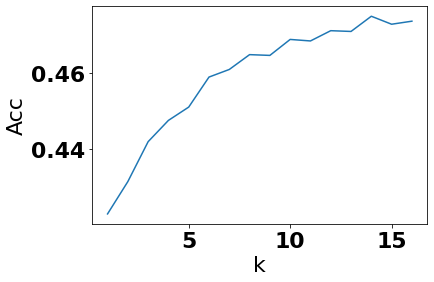

In [49]:
plt.plot(np.arange(1,len(accs)+1), accs)
plt.xlabel("k")
plt.ylabel("Acc")
plt.show()

In [ ]:
# Model1: 0.4649
# ViT Baseline: 0.2882
# Model1: 0.502

In [34]:
df = pd.DataFrame({ "Model Architecture": ["TreeCNN", "ViT Tiny"], "Accuracy": [50.20, 28.82] })
df

,Model Architecture,Accuracy
0,TreeCNN,50.20
1,ViT Tiny,28.82


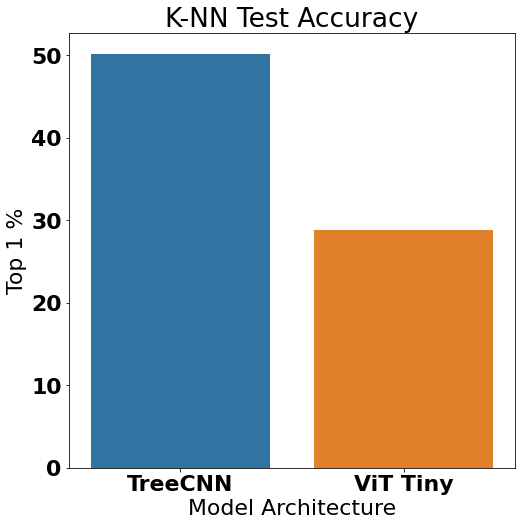

In [38]:
fig = plt.figure(figsize=(8,8))
sns.barplot(x="Model Architecture", y="Accuracy", data=df)
plt.ylabel("Top 1 %")
plt.title("K-NN Test Accuracy")
plt.savefig("knn3_preliminary_barchart.png")
#plt.show()
##plt.bar([1,2], [50.20, 28.82])
#plt.bar([1], [50.20], color=)
#plt.bar([2], [28.82])